# Locus Shots

Browser shots same as GenomeShots.ipynb with peak-gene links, motif hits and perhaps Hi-C.

**Inputs**: 
1. Config:
    - For each cluster, colour, description, new cluster number (set to same as original if it should not be changed)
2. Bigwig files per cluster
3. Seurat RNA file
4. ATAC->RNA cluster transfer tsv (should be same cluster IDs as old IDs)
5. Peaks 
6. Peaks->Gene correlation links

In [1]:
library(ggplot2)
library(Gviz)
library(GenomicRanges)
library(patchwork)
library(ggplotify)
library(rtracklayer)
library(Seurat)
library(cicero)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min



Attaching package: ‘S4Vectors’


The

In [2]:
DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14", "iPSC")

## Loading Inputs

### Day and Cluster Configs

In [3]:
day_config = read.table("./configs/day.tsv", comment.char = '', header=T)
day_config$colour = as.character(day_config$colour)
day_config$day = factor(day_config$day, levels=DAYS)
rownames(day_config) = day_config$day
day_config

,day,colour
,<fct>,<chr>
D0,D0,#A61C24
D2,D2,#FF70A6
D4,D4,#D6E82F
D6,D6,#B14AED
D8,D8,#2D3142
D10,D10,#FC7753
D12,D12,#0AABB7
D14,D14,#336699
iPSC,iPSC,#13C4A3


In [4]:
cluster_config = read.table("./configs/cluster.tsv", comment.char = '', header=T, sep='\t')
cluster_config$colour = as.character(cluster_config$colour)
cluster_config$description = as.character(cluster_config$description)

# print friendly
cluster_config[9, "description"] = "Partially\nreprogrammed"

rownames(cluster_config) = cluster_config$cluster
cluster_config

,cluster,colour,description,new_cluster
,<int>,<chr>,<chr>,<int>
1,1,#B03743,Fibroblast,1
2,2,#E85F6D,Fibroblast-like,3
3,3,#7C2730,Fibroblast-like,2
4,4,#F0A118,Intermediate,12
5,5,#78A824,Pre-iPSC,13
6,6,#A6D854,Pre-iPSC,14
7,7,#F01D35,Fibroblast-like,5
8,8,#13C4A3,iPSC,15
9,9,#406614,Partially reprogrammed,10


### BigWig List

In [5]:
cluster_bigwigs = read.table("./configs/cluster_bigwigs.tsv", header=T)
cluster_bigwigs$path = as.character(cluster_bigwigs$path)
rownames(cluster_bigwigs) = cluster_bigwigs$cluster
head(cluster_bigwigs)

,cluster,path
,<int>,<chr>
1,1,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20210714_n64913/croo/cluster_idx1/signal/rep1/cluster_idx1.pval.signal.bigwig
2,2,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20210714_n64913/croo/cluster_idx2/signal/rep1/cluster_idx2.pval.signal.bigwig
3,3,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20210714_n64913/croo/cluster_idx3/signal/rep1/cluster_idx3.pval.signal.bigwig
4,4,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20210714_n64913/croo/cluster_idx4/signal/rep1/cluster_idx4.pval.signal.bigwig
5,5,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20210714_n64913/croo/cluster_idx5/signal/rep1/cluster_idx5.pval.signal.bigwig
6,6,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20210714_n64913/croo/cluster_idx6/signal/rep1/cluster_idx6.pval.signal.bigwig


### Gene Model

In [6]:
gencode.basic.hg38 = import.gff(gzfile("../../resources/GENCODE/gencode.v33.chr_patch_hapl_scaff.basic.annotation.gtf.gz"))
gencode.basic.hg38 = keepStandardChromosomes(gencode.basic.hg38, pruning.mode = "coarse")
gene_anno <- data.frame(gencode.basic.hg38)
gene_anno = gene_anno[!is.na(gene_anno$exon_number), ]
gene_anno = gene_anno[gene_anno$gene_type=="protein_coding", ]

# rename some columns to match requirements
gene_anno$chromosome <-  gene_anno$seqnames
gene_anno$gene <- gene_anno$gene_id
gene_anno$transcript <- gene_anno$transcript_name
gene_anno$symbol <- gene_anno$gene_name

gene_anno$feature = as.character(gene_anno$type)
gene_anno$exon = gene_anno$exon_id
gene_anno = gene_anno[,c("chromosome", "start", "end", "strand", "gene", "symbol", "transcript", "feature", "exon")]
head(gene_anno)

Warning message in readGFF(filepath, version = version, filter = filter):
"connection is not positioned at the start of the file, rewinding it"


,chromosome,start,end,strand,gene,symbol,transcript,feature,exon
,<fct>,<int>,<int>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>
57,chr1,65419,65433,+,ENSG00000186092.6,OR4F5,OR4F5-202,exon,ENSE00003812156.1
58,chr1,65520,65573,+,ENSG00000186092.6,OR4F5,OR4F5-202,exon,ENSE00003813641.1
59,chr1,65565,65573,+,ENSG00000186092.6,OR4F5,OR4F5-202,CDS,ENSE00003813641.1
60,chr1,65565,65567,+,ENSG00000186092.6,OR4F5,OR4F5-202,start_codon,ENSE00003813641.1
61,chr1,69037,71585,+,ENSG00000186092.6,OR4F5,OR4F5-202,exon,ENSE00003813949.1
62,chr1,69037,70005,+,ENSG00000186092.6,OR4F5,OR4F5-202,CDS,ENSE00003813949.1


In [15]:
gene_anno_subset = gene_anno[gene_anno$symbol=="NANOG",]
gene_anno_subset = gene_anno_subset[gene_anno_subset$feature=="start_codon",]

### Seurat Object

In [7]:
rna = readRDS("../analysis/20200828_RNA_Seurat/sessions/20210725_n59378/seurat.rds")

### ATAC-RNA Label Transfer

In [11]:
atac.rna.label = read.table("../analysis/20200828_RNA_Seurat/sessions/20210725_n59378/atac.20210717_n62599.cluster.transfer.tsv",
                           header=T)
rownames(atac.rna.label) = atac.rna.label$barcode
atac.rna.label$barcode = NULL

all(rownames(atac.rna.label)==colnames(rna))

# transfer to new cluster
atac.rna.label$atac_new_cluster = cluster_config[atac.rna.label$atac_cluster, "new_cluster"]

head(atac.rna.label)

[1] TRUE

,sample,atac_cluster,atac_new_cluster
,<fct>,<int>,<int>
AAACCCAAGAGTGACC-1,D0,1,1
AAACCCAAGTGCCAGA-1,D0,1,1
AAACCCACACCATTCC-1,D0,1,1
AAACCCACACGCGTCA-1,D0,1,1
AAACCCAGTCCATAGT-1,D0,1,1
AAACCCAGTTATTCTC-1,D0,1,1


### Peak Set

In [12]:
peak_set = import("../analysis/20200206_pmat_snapATAC/sessions/20210717_n62599/peaks.bed")
peak_set

GRanges object with 530910 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]    chr17 32960818-32961317      *
       [2]    chr17 75764253-75764752      *
       [3]    chr17   1473115-1473614      *
       [4]    chr17   4206898-4207397      *
       [5]    chr17     423410-423909      *
       ...      ...               ...    ...
  [530906]     chrY   7260942-7261441      *
  [530907]     chrY 13337358-13337857      *
  [530908]     chrY   7109992-7110491      *
  [530909]     chrY 13241192-13241691      *
  [530910]     chrY   7936007-7936506      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

### Peak->Gene Correlation Links

In [7]:
peak_gene_links = read.table("../analysis/20200925_Peak2Gene/peak2gene_links/RNA_20210725_n59378_ATAC_20210717_n62599/20210826_all_fdr1e-4.tsv",
                            header=T,
                            stringsAsFactors=F)
head(peak_gene_links)

,peak,gene,Correlation,FDR,VarQATAC,VarQRNA
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr1:585929-586429,LINC01128,-0.2158628,3.378152e-06,0.8456104,0.4633998
2,chr1:737946-738446,LINC01128,0.2013441,1.605483e-05,0.5514626,0.4633998
3,chr1:826825-827325,LINC01128,0.1918765,4.172571e-05,0.8919647,0.4633998
4,chr1:845596-846096,LINC01128,-0.1872592,6.534200e-05,0.5450585,0.4633998
5,chr1:858621-859121,LINC01128,-0.1851962,7.956006e-05,0.7429790,0.4633998
6,chr1:906705-907205,LINC01128,0.5794615,1.330099e-44,0.9578667,0.4633998


## Plotting

In [8]:
get_region_tracks <- function(chr, cluster_config, cluster_bigwigs, show_axis=T) {
    # NOTE: this does not perform any max aggregation
    
    bw_tracks = c()
    for (i in seq(nrow(cluster_config))) {
        cur_bw_path = cluster_bigwigs[i, "path"]
        cur_bw_track = DataTrack(cur_bw_path, 
                             genome="hg38", 
                             chromosome = chr, 
                             name=sprintf("%s", cluster_config[i, "new_cluster"]),
                             ylim=c(0,42),
                             type="histogram",
                             col.histogram=cluster_config[i, "colour"],
                             fill.histogram=cluster_config[i, "colour"],
                             background.title = cluster_config[i, "colour"], littleTicks=F)
        
        # don't show axis ticks for each plot
        displayPars(cur_bw_track)$showAxis = F
        if (!show_axis) {
            displayPars(cur_bw_track)$showTitle = F
        }
        
        bw_tracks = c(bw_tracks, cur_bw_track)
    }
    
    bw_tracks = bw_tracks[order(cluster_config$new_cluster)] # reorder
    
    if (!show_axis) {
            displayPars(gene_track)$showTitle = F
            displayPars(gene_track)$showAxis = F
        }
    
    bw_tracks
}

get_gene_track <- function(chr, gene_anno, show_axis=T) {
    gene_track <- GeneRegionTrack(gene_anno, genome = "hg38", 
                                 chromosome = chr, 
                                 name = "", 
                                 collapseTranscripts="longest",
                                 transcriptAnnotation="symbol",
                                background.title = 'transparent',
                                  background.panel = "#FFFEDB",
                                fill='#000000',
                                stackHeight=0.5)
    if (!show_axis) {
            displayPars(gene_track)$showTitle = F
        }
    
    gene_track
}

In [9]:
cluster_config$new_cluster

[1]  1  3  2 12 13 14  5 15 10  9  8  4  6 11  7

In [10]:
get_expression_plot <- function(values, clusters) {
    df = data.frame(val=values,
                   clst=clusters)
    
    plot <- ggplot(df, 
               aes(x=clst,y=val,fill=clst)) +
        geom_violin(scale="width") +
        stat_summary(fun=median, geom="point", size=2, color="black") +
        scale_x_discrete(limits=factor(rev(sort(cluster_config$new_cluster)))) +
        scale_y_continuous(position="right",
                           breaks = function(x) unique(floor(pretty(seq(0, (max(x) + 1) * 1.1))))) + # for integer breaks only
        scale_fill_manual(values=as.character(cluster_config$colour[order(cluster_config$new_cluster)])) +
        ylab("scRNA") +
        coord_flip() +
        theme_classic() +
        theme(plot.title = element_text(hjust = 0.5),
                  text = element_text(size=12),
        #           axis.line=element_blank(),
        #           axis.text.x=element_blank(),
        #           axis.title.x = element_blank(),
                  axis.title.y = element_blank(),
                  axis.text.y=element_blank(),
                  axis.ticks.y=element_blank(),
                  panel.border = element_rect(colour = "black", fill=NA, size=0.5),
                  legend.position = "none") 
    plot
}

In [11]:
get_peaks_track <- function(chr, peaks, from, to, show_axis=T) {
    peak_subset = peaks[seqnames(peaks)==chr]
    peak_subset = peak_subset[start(peak_subset) >= from]
    peak_subset = peak_subset[end(peak_subset) <= to]
    
    peaks_track <- AnnotationTrack(start=start(peak_subset),
                                  width=width(peak_subset),
                                  genome = "hg38", 
                                 chromosome = chr, 
                                 name = "", 
                                background.title = 'transparent',
                                fill='#000000',
                                stackHeight=0.5)
    if (!show_axis) {
            displayPars(peaks_track)$showTitle = F
        }
    
    peaks_track
}

In [12]:
get_connections_track <- function(chr, selected_gene, p2g, gene_anno, from, to, corr_cutoff=0.45, connection_color = "#7F7CAF", show_axis=T) {
    p2g_subset = p2g[p2g$gene == selected_gene, ]
    p2g_subset_gr = GRanges(p2g_subset$peak)
    p2g_subset = p2g_subset[(start(p2g_subset_gr) > from)&(end(p2g_subset_gr) < to), ]
    
    # find gene start point
    gene_anno_subset = gene_anno[gene_anno$symbol==selected_gene,]
    gene_anno_subset = gene_anno_subset[gene_anno_subset$feature=="start_codon",]
    
    stopifnot(length(unique(gene_anno_subset$strand))==1)
    
    if (unique(gene_anno_subset$strand)=="+") {
        start = min(gene_anno_subset$start)
    }
    else {
        start = max(gene_anno_subset$start)
    }
    
    plot_conn_df = data.frame(Peak1=sub("-", "_", sub(":", "_", p2g_subset$peak)),
                              Peak2 = paste(CHR, start, start+1, sep="_"),
                             coaccess=p2g_subset$Correlation)
    
    plot_conn_df = plot_conn_df[plot_conn_df$coaccess > corr_cutoff, ]
    
    if (nrow(plot_conn_df) == 0) {
        conns_track <- AnnotationTrack()
    }
    
    else {
        conns_track <- plot_connections(plot_conn_df,
                                        chr=chr,
                                        minbp=from,
                                        maxbp=to,
                                        coaccess_cutoff = corr_cutoff, 
                                        connection_color = connection_color,
                                        return_as_list=T)[[1]]
    }

    displayPars(conns_track)$col.axis = 'black'
    displayPars(conns_track)$background.title = 'transparent'
    
    if (!show_axis) {
            displayPars(conns_track)$showTitle = F
        }
    
    conns_track
}

### Prototype

In [13]:
bw_tracks = get_region_tracks("chr1",cluster_config[1:2,], cluster_bigwigs, show_axis=T)

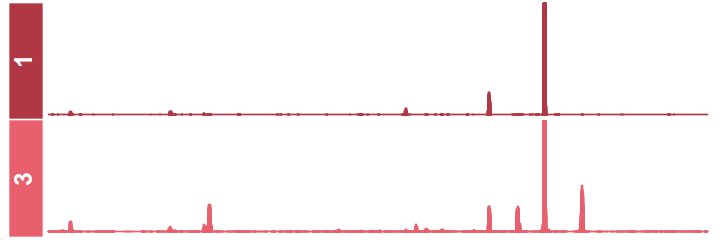

In [14]:
options(repr.plot.width = 6, repr.plot.height = 2)
as.ggplot(~plotTracks(bw_tracks, from=68720914, to=68851918))

In [17]:
gene_track = GeneRegionTrack(gene_anno, genome = "hg38", 
                                 chromosome = "chr1", 
                                 name = "", 
                                 collapseTranscripts="longest",
                                 transcriptAnnotation="symbol",
                                background.title = 'transparent')

gene_track2 = GeneRegionTrack(gene_anno, genome = "hg38", 
                                 chromosome = "chr1", 
                                 name = "", 
                                 collapseTranscripts="longest",
                                 transcriptAnnotation="symbol",
                                background.title = 'transparent',
                             stackHeight=0.5, fill='#000000', min.height=20)

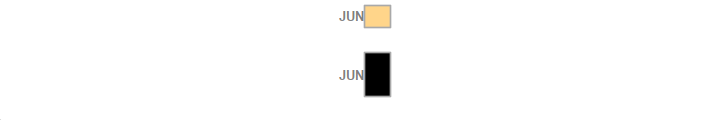

In [18]:
options(repr.plot.width = 6, repr.plot.height = 1)

as.ggplot(~plotTracks(c(gene_track, gene_track2), from=58740914, to=58823989, sizes=c(1,3)))

## Panels

In [20]:
HIGHLIGHT_COL = "#f5f5f5"

In [21]:
# bw_tracks = get_region_tracks("chr16", cluster_config, cluster_bigwigs, show_axis=F)
# gene_track = get_gene_track("chr16", gene_anno, show_axis=F)
# bw_highlighted = HighlightTrack(trackList = bw_tracks,
#                                start=c(68731000, 68777300), 
#                                end=c(68740000, 68780500), 
#                                chromosome="chr16",
#                                col=HIGHLIGHT_COL, fill=HIGHLIGHT_COL)

# FROM = 68720914
# TO = 68851918
# CDH1 = as.ggplot(~plotTracks(c(bw_highlighted), 
#                              from=FROM, to=TO, 
#                              sizes=rep(1,nrow(cluster_config)))) +
#        ggtitle("CDH1") +
#        theme(plot.title = element_text(hjust = 0.5, size=20),
#              panel.border = element_rect(colour = "black", fill=NA, size=0.5))
# CDH1_gene = as.ggplot(~plotTracks(gene_track, from=FROM, to=TO)) 

### NANOG

In [88]:
CHR = "chr12"
FROM = 7635689
TO = 7810787

bw_tracks = get_region_tracks(CHR, cluster_config, cluster_bigwigs, show_axis=T)
gene_track = get_gene_track(CHR, gene_anno, show_axis=T)
bw_highlighted = HighlightTrack(trackList = bw_tracks,
                               start=c(), 
                               end=c(), 
                               chromosome=CHR,
                               col=HIGHLIGHT_COL, fill=HIGHLIGHT_COL)

NANOG = as.ggplot(~plotTracks(bw_highlighted, from=FROM, to=TO,
                             sizes=rep(1,nrow(cluster_config))))+
       theme(panel.border = element_rect(colour = "black", fill=NA, size=0.5))

NANOG_gene = as.ggplot(~plotTracks(gene_track, from=FROM, to=TO)) 

In [23]:
peaks_track = get_peaks_track(CHR, peak_set, FROM, TO, show_axis=T)

In [24]:
GENE = "NANOG"

In [25]:
CUTOFF=0.45

In [26]:
conn_track = get_connections_track(CHR, GENE, peak_gene_links, gene_anno, FROM, TO, corr_cutoff=CUTOFF, show_axis=T)

In [27]:
neg_peak_gene_links = peak_gene_links
neg_peak_gene_links$Correlation = -neg_peak_gene_links$Correlation
neg_conn_track = get_connections_track(CHR, GENE, neg_peak_gene_links, gene_anno, FROM, TO, corr_cutoff=CUTOFF, connection_color= "red", show_axis=T)

In [28]:
options(repr.plot.width = 8, repr.plot.height = 4)

anno = as.ggplot(~plotTracks(c(conn_track, neg_conn_track, peaks_track), from=FROM, to=TO,
                            sizes=c(3,3,2))) + 
       ggtitle(GENE) + theme(plot.title = element_text(hjust = 0.5, size=20))

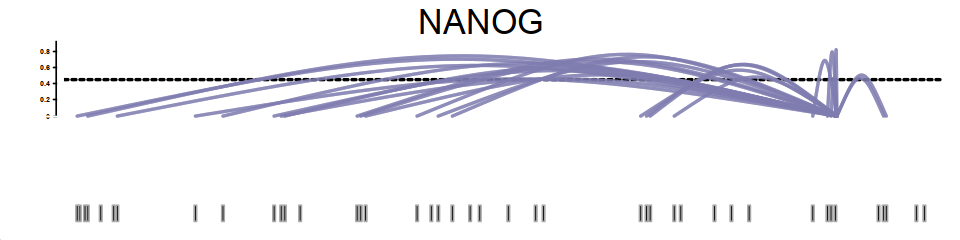

In [29]:
options(repr.plot.width = 8, repr.plot.height = 2)

anno

In [66]:
# CDH1_expr = get_expression_plot(as.vector(rna[['RNA']]["CDH1"]), factor(atac.rna.label$atac_new_cluster))
GENE_expr = get_expression_plot(as.vector(rna[['RNA']][GENE]), factor(atac.rna.label$atac_new_cluster))

In [70]:
DPPA3_expr = get_expression_plot(as.vector(rna[['RNA']]["DPPA3"]), factor(atac.rna.label$atac_new_cluster))
GDF3_expr = get_expression_plot(as.vector(rna[['RNA']]["GDF3"]), factor(atac.rna.label$atac_new_cluster))

In [84]:
cluster_label_df = cluster_config

# BOTTOM_PT = nrow(cluster_label_df)+0

# cluster_label_df[nrow(cluster_label_df)+1, ] = c(nrow(cluster_label_df)+1, "", "", 1)
# cluster_label_df[nrow(cluster_label_df)+1, ] = c(nrow(cluster_label_df)+1, "", "", BOTTOM_PT)

# need to play around with these parameters to find the right fit
cluster_labels_plot <- ggplot(cluster_label_df) +
    geom_text(aes(x=0, y= -as.numeric(new_cluster), label=description, hjust=1, vjust=0.5)) +
    theme_void(base_size=15) +
    theme(plot.margin = unit(c(0,-95,0,0), "pt"))
# wrap
cluster_labels_plot = wrap_plots(plot_spacer(), cluster_labels_plot, plot_spacer(), widths=c(0,1,0))


# add to debug- shows how ggplot dots align with genome track labels
# for (i in seq(1,18)) {
#     cluster_labels_plot = cluster_labels_plot + geom_point(x=0, y= -i)
# }

# cluster_labels_plot = cluster_labels_plot + geom_point(x=0, y= -BOTTOM_PT, colour='red')

In [89]:
WIDTHS_MAIN = c(1,11.5,0.5, 0.5, 0.5)
WIDTHS = c(1,11.5,1.5)

top = wrap_plots(plot_spacer(),
                anno,
                plot_spacer(),
                widths=WIDTHS)

mid = wrap_plots(cluster_labels_plot,
                    NANOG,
                    GENE_expr,
                    GDF3_expr,
                    DPPA3_expr,
           widths=WIDTHS_MAIN)

bottom = wrap_plots(plot_spacer(),
                    NANOG_gene,
                    plot_spacer(),
                    widths=WIDTHS)

myplot = wrap_plots(top, 
                    plot_spacer(),
                    mid,
                    bottom,
                    heights=c(2,-.8,11,1.5))

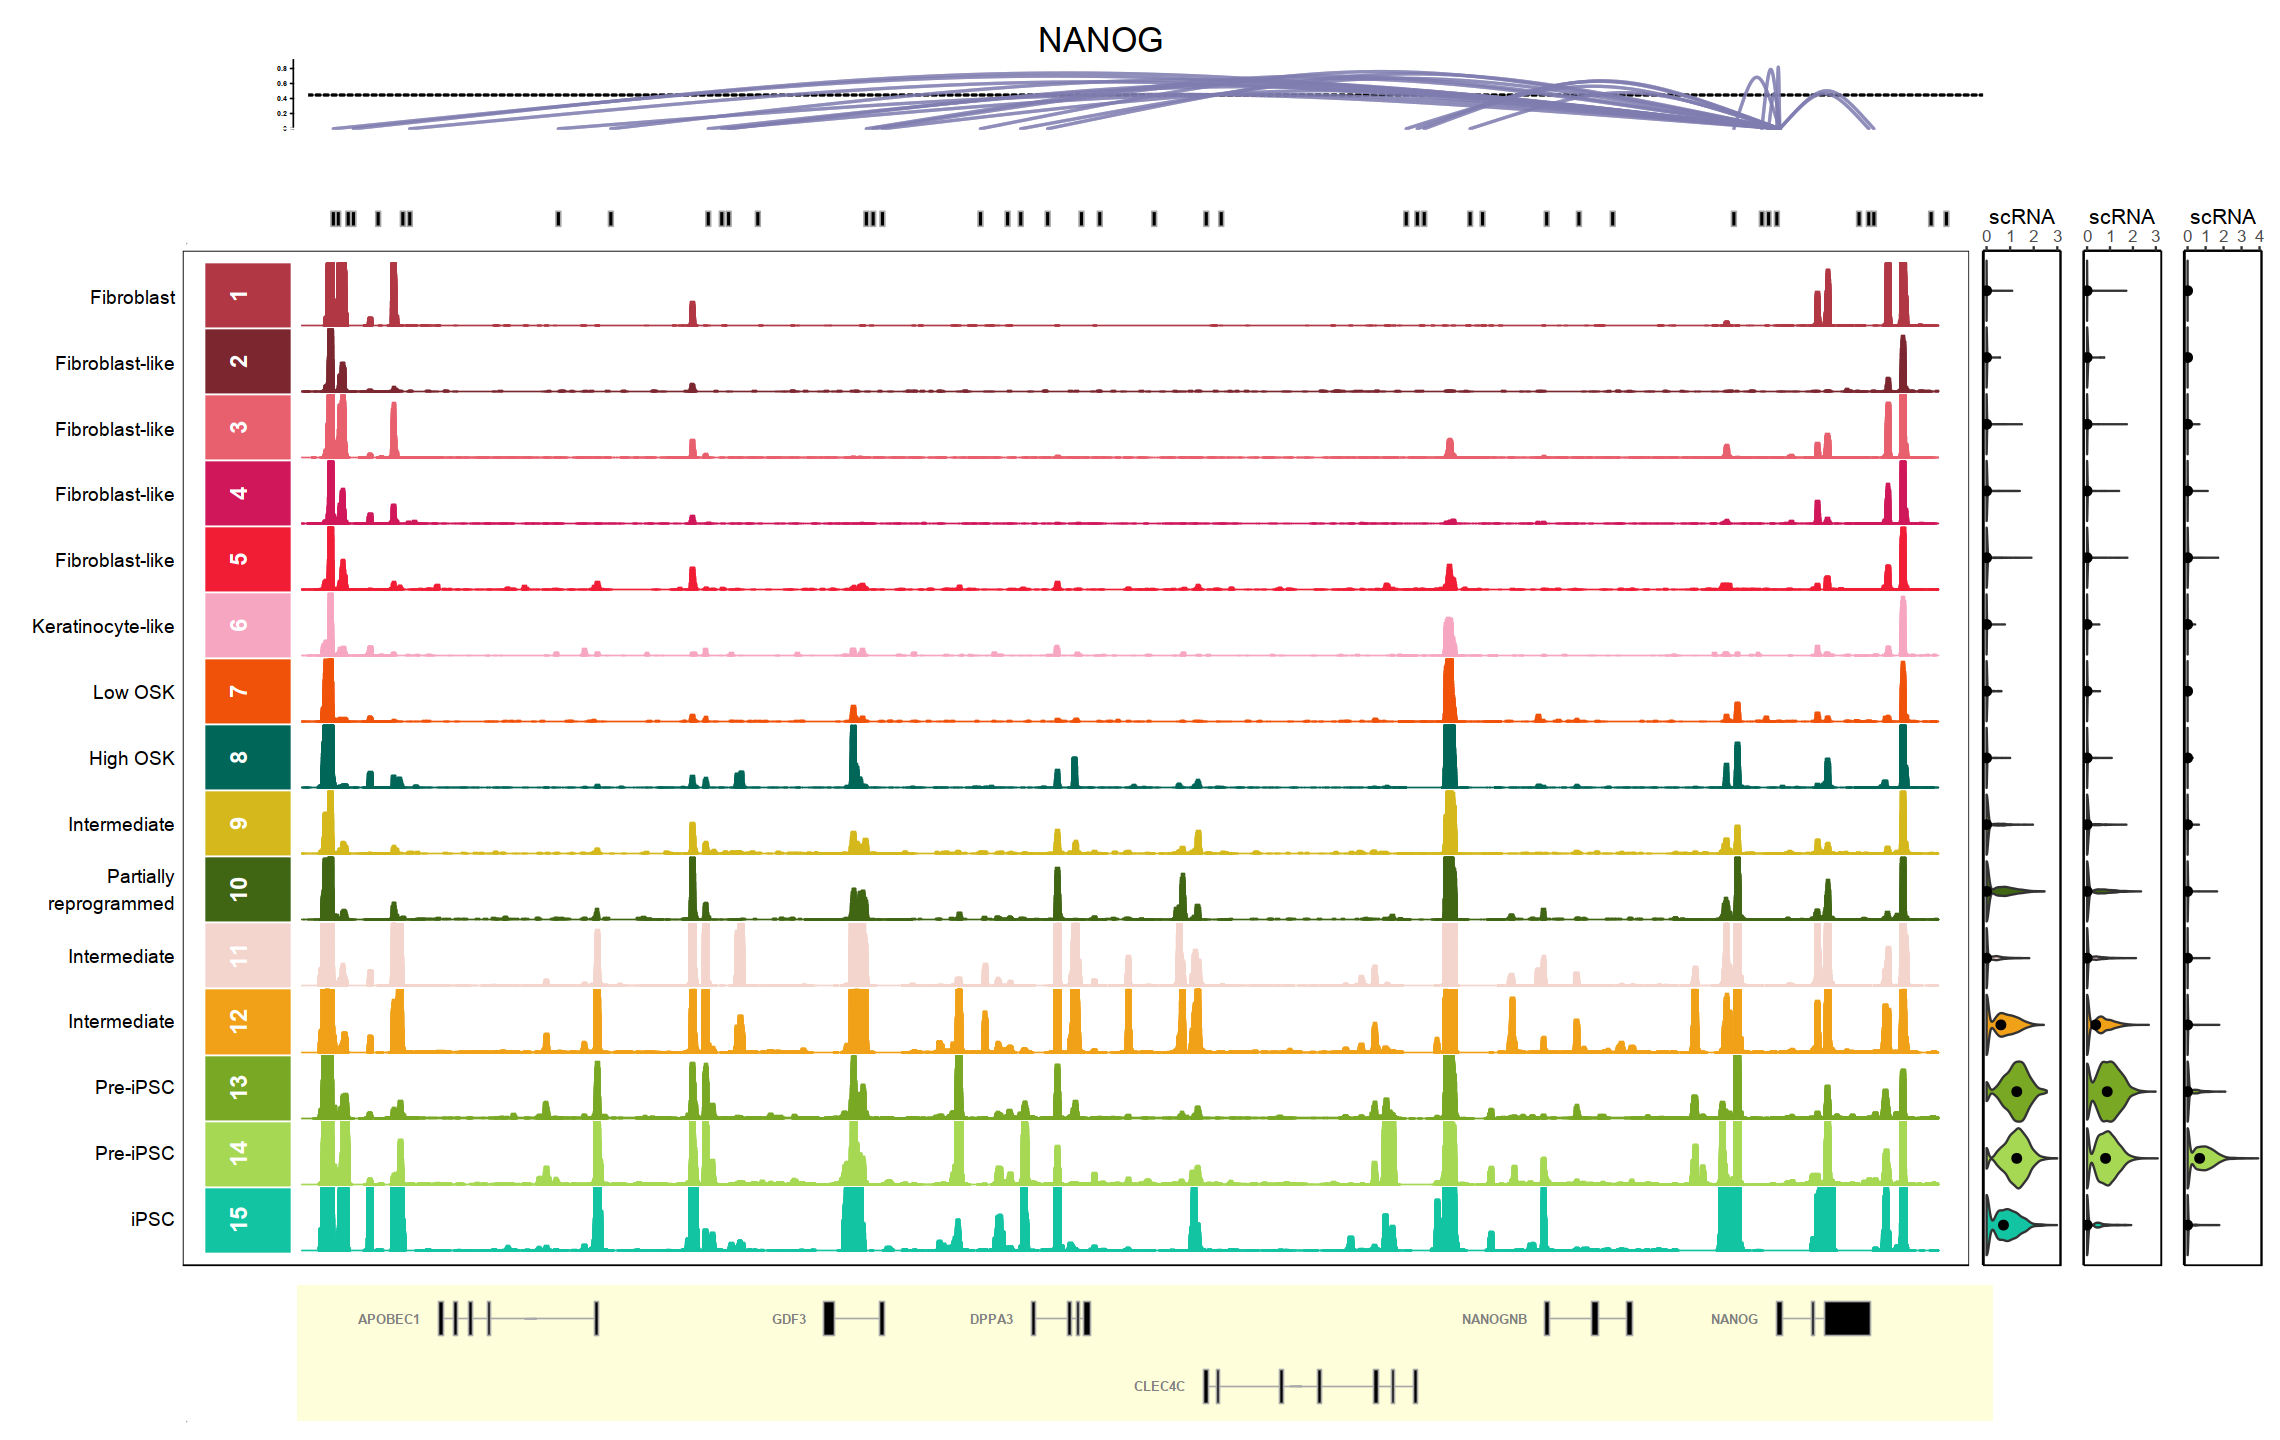

In [90]:
options(repr.plot.width = 19, repr.plot.height = 12)

myplot

In [93]:
ggsave("./Fig6/subfigs/NANOG_gene.pdf", NANOG_gene, height=1, width=10, useDingbats = F)

In [81]:
ggsave("./Fig6/subfigs/locus_w_NANOG_GDF3_DPPA3_expr.pdf", myplot, height=12, width=19, useDingbats = F)

---

In [76]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] cicero_1.3.4.8              monocle3_0.2.3.0           
 [3] SingleCellExperiment_1.8.0  SummarizedExperiment_1.16.1
 [5] DelayedArray_0.12.3         BiocParallel_1.20.1        
 [7] matrixStats_0.56.0          Biobase_2.46.0             
 [9] Seurat_3.1.5  